<span style="font-family:Helvetica; color:gray">These exercise materials provided to you as a student of Aalto University are protected by copyright. You are authorized to use these materials for your personal educational purposes, including completing the exercises and submitting them for grading. You are prohibited from reproducing, distributing, displaying, or sharing any portion of these materials in any form, including, but not limited to, posting on the internet or other forms of electronic communication. Aalto University reserves all rights in the exercise materials.</span>


## Exercise 2: The Schelling model
The purpose of this exercise is to learn basics of agent-based modelling by programming a version of the Schelling model and investigating its behavior.

The Schelling model is a simple model developed in the 1970s to demonstrate how a small preference towards living next to one's own group can lead to wide-scale segregation within cities. The model is an archetypical example of emergence in agent-based models: the behavior of individual agents, when combined together, leads to unexpected large-scale consequences. The model was listed in the grounds for the 2005 Nobel prize in economics for Schelling.  

In this exercise you are given a set of generic classes that can be used for agent-based models, and your task is to fill in the details. 

Let's start by importing some libraries and a helper class that we need. (You don't need to look at the implementation of the helper class.)

In [16]:
import numpy
import random
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation, ImageMagickWriter
import matplotlib
matplotlib.rcParams.update({'font.size': 13.5})

class IndexedSet(object):
    """A set where each element also has an index from 0 to n-1. Indices are updated if
    the an element is removed from the set.
    """
    def __init__(self):
        self._list = []
        self._element_to_index = {}

    def remove_element(self,element,assertion=True):
        if element not in self._element_to_index:
            if assertion:
                raise KeyError("No such element: " + str(element))
            return False

        element_index = self._element_to_index[element]

        # Remove from the list
        last_element = self._list[-1]
        self._list[-1], self._list[element_index] = self._list[element_index], self._list[-1] #Swap in list
        self._element_to_index[last_element] = element_index # Update index
        self._list.pop()

        # Remove from the dict
        del self._element_to_index[element]
        
        return True

    def add_element(self, element):
        assert element not in self._element_to_index, "Element already in the set: " + str(element) 
        self._element_to_index[element] = len(self._list)
        self._list.append(element)

    def get_element(self, index):
        return self._list[index]

    def pop_index(self, index):
        element=self.get_element(index)
        self.remove_element(element)
        return element

    def pop_random(self):
        index=random.randint(0, len(self) - 1)
        return self.pop_index(index)

    def random(self):
        index = random.randint(0, len(self) - 1)
        return self.get_element(index)

    def __len__(self):
        return len(self._list)
    

The classes that you will be working with are:

- `Grid`: This class represents the environment for the agents. It represents a square grid, where every grid location has x and y coordinates, and each grid location is neighbored by the 8 directions (except at the borders of the grid). There is no need to modify this class in this exercise, and it is provided for convenience so you don't have to implement the most basic operations related to manipulating a square grid.

- `Agent`: Instances of this class represent the individual agents in your simulations. The class has a method called `act` that is called in the simulation repeatedly for every agent, and implements the decisions and actions of the agent. **You will be filling in the `act` method.**

- `Simulation`: Instances of this class represent simulation runs. **You will need to fill in the rules on how the agents are initially placed on the grid and how the simulation is updated.**

Plan for completing this exercise:

 1. **Run all the code in this file and make sure that you can run it as provided.** There should be no errors popping up under the course server on CS JupyterHUB. Please keep in mind that you may need to install ImageMagick elsewhere. As given, the code produces an empty grid, and nothing happens during the updates. You can familiarize yourself with the classes and methods that are already implemented. There is no need to inspect the implemented parts in detail, but it is enough to know what methods are available for you. Check in specific the example usage of the `Grid` class in the code comments.

 2. **Go and fill in the implementation of the `__init__` method of the `Simulation` class.** See the instructions in the method. Run the code again and you should be able to see the agents appear in the grid in random places. The agents are still not doing anything.

 3. **Go and implement the `act` method of the `Agent` class**. This is the core of the simulation, as it determines how the agents interact with each other and the environment. Run the code again, and you should be seeing behavior that you would expect from the Schelling model. You can already start playing with different parameters of the model and seeing how the neighborhoods are formed in different ways as a consequence.

 4. **Go and implement the `update_roundrobin` method of the `Simulation` class.** This is an alternative method randomising the order at which the agents act. You can then experiment its difference to the `update_withreplacement` method by replacing which function you call in the `animate` function.

As you will see, building agent-based simulations is not difficult. Even implementing a Nobel-prize-winning one is only a small exercise! The basics of other agent-based simulations, even the more complicated ones, are very similar to this one, and you are now ready to implement your own ones.

Good luck with your implementation! The code template is provided as follows.

In [17]:
class Grid:
    """Grid class for represeting 2-dimensional environment for the agents.

    Agents can be accessed using Python's standard get and set notation.
    Locations in the grid are represented with tuples (i,j).
    Example usage:
    
    myGrid = Grid(10, 10)  # Create a 10x10 grid
    myGrid[5, 5] = Agent(color=(1, 0, 0)) # Create an agent of red color and add it to position (5,5) in myGrid
    myGrid[5, 5]  # Return the agent we just created tp
    myGrid[5, 5] = None  # Set the grid position (5, 5) empty
    for loc in myGrid.neighbors((5, 5)):  # Iterate over all neighbor locations of grid position (5,5)
        if not myGrid.is_free(loc):  # If the location is not empty
            yield myGrid[loc].color  # Return the color of the agent in the location
    """
    def __init__(self, n, m, simulation=None):
        """Create an empty n x m grid.
        """
        self.n = n
        self.m = m
        self.sim = simulation
        self._grid = []
        self.empty = IndexedSet()
        
        for i in range(n):
            l = []
            self._grid.append(l)
            for j in range(m):
                l.append(None)
                self.empty.add_element((i, j))
                
    def __getitem__(self, item):
        self._assert_location(item)
        return self._grid[item[0]][item[1]]

    def __setitem__(self, item, val):
        self._assert_location(item)
        if val == None:
            if not self.is_free(item):
                self.empty.add_element(item)
        elif self.is_free(item):
            self.empty.remove_element(item)
        
        if isinstance(val, Agent):
            val.env = self   
            val.location = item

        self._grid[item[0]][item[1]] = val

    def nonempty(self):
        """Iterates over all grid locations that are not empty.

        Returns grid coordinates as a tuple (i, j).
        """
        for i in range(self.n):
            for j in range(self.m):
                element = self._grid[i][j]
                if element != None:
                    yield (i, j)

    def agents(self):
        """Iterates over all agents in the grid.
        """
        for location in self.nonempty():
            yield self[location] # If it is not empty, it is an agent

    def _neighbors_all(self, item):
        yield item[0] - 1, item[1]     # left
        yield item[0] - 1, item[1] - 1   # upper left
        yield item[0] - 1, item[1] + 1   # lower left
        yield item[0] + 1, item[1]     # right
        yield item[0] + 1, item[1] - 1   # upper right
        yield item[0] + 1, item[1] + 1   # lower right
        yield item[0], item[1] - 1     # up
        yield item[0], item[1] + 1     # down
        
    def _is_valid_location(self, item):
        return item[0] >= 0 and item[1] >= 0 and item[0] < self.n and item[1] < self.m

    def _assert_location(self, location):
        assert self._is_valid_location(location), "Invalid location" + str(location)

    def neighbors(self, location):
        """Iterates over all grid locations that are neighbors of the given location.

        Returns grid coordinates as a tuple (i, j).
        """
        self._assert_location(location)

        for neighbor in self._neighbors_all(location):
            if self._is_valid_location(neighbor):
                yield neighbor
    
    def random_free(self):
        """Returns a uniformly randomly chosen free location. Grid coordinates returned as a tuple (i,j).
        """
        if len(self.empty) == 0:
            raise ValueError("No empty locations in the grid.")
        return self.empty.random()  

    def random_agent(self):
        """Returns a uniformly randomly agent.
        """
        if len(self.empty) == self.n*self.m:
            raise ValueError("Cannot select a random agent in an empty grid.")
        while True:
            location = (random.randint(0, self.n - 1), random.randint(0, self.m - 1))
            if isinstance(self[location], Agent):
                return self[location]

    def is_free(self, location):
        """Returns true if the location is empty.
        """
        self._assert_location(location)
        return self[location] == None

    def number_of_agents(self):
        """Returns the number of agents on the grid.
        """
        return self.n*self.m - len(self.empty)


In [18]:
class Agent:
    def __init__(self, color, environment=None, location=None):
        self.env = environment
        self.color = color
        self.location = location
        
    def act(self):
        """Perform one action for this agent.
        """
        # This is the method that will be called when it's the agents turn to act. It will encode most of the logic of the
        # current model.
        # Your task is to fill this method for the variant of the Schelling model we are investigating. To organise your work
        # we have created an (empty) function called 'same_color_fraction' that you can fill in first, and then move on to the
        # rest. See the instructions below.

        def same_color_fraction(location):
            """
            This function returns the fraction of agents that are the same color as this agent in the neighborhood
            of the 'location' given as a parameter. If there are no agents in the neighborhood, it will return 1.
            """
            # Fill in the functionality described above. Note that you can use the 'self.env.neighbors(location)' method
            # to iterate over all the positions in the neighborhood of the location, and 'self.env.is_free(location)' to check
            # if a location is empty. Remember to check for the special case where there are no agents in the neighborhood.
            same_color_agent_neighbors = 0
            number_of_agent_neighbors = 0
            for neighborLocation in self.env.neighbors(location):
                if not self.env.is_free(neighborLocation):
                    number_of_agent_neighbors += 1
                    if self.env[neighborLocation].color == self.color:
                        same_color_agent_neighbors += 1
            if number_of_agent_neighbors == 0:
                return 1
            else:
                return same_color_agent_neighbors/number_of_agent_neighbors
            # Your code here.

        # Fill in the logic which the agent uses to move in this version of the Schelling model:
        # 1. Use the 'same_color_fraction' function to compute color fraction t
        # 2. Compare the color fraction to the intolerance level, which you can access from 'self.env.sim.parameters["intolerance"]'
        # 3. If the fraction of same color agents is less than the intolerance the agent will attempt to move to a 
        # random free location in the grid. You can get such random location with the 'self.env.random_free()' method.
        # 4. If the fraction of neighbors with the same color in the new location is worse than the current location,
        # then the agent doesn't make the move. Otherwise it moves to the new location.
        # To move the current agent, update the agent's location ('self.location'), assign 'self'
        # (i.e. this current agent) to the new location in the grid, and assign None to the old location of the agent
        # on the grid.
        intolerance = self.env.sim.parameters["intolerance"]
        t = same_color_fraction(self.location)
        #print("fraction")
        #print(t)
        if t < intolerance:
            new_random_location = self.env.random_free()
            if t < same_color_fraction(new_random_location):
                old_location = self.location
                self.location = new_random_location
                self.env[new_random_location] = self
                self.env[old_location] = None 
        # Your code here.
        

In [19]:
class Simulation:
    def __init__(self, n, m, nagents, parameters={}):
        """Initializes the simulation with n x m grid that has given number of agents in random
        locations of the grid.
        """
        self.parameters = parameters
        self.env = Grid(n, m, simulation=self)
        red = (1, 0, 0)
        blue = (0, 0, 1)

        # Create 'nagents' number of agents to populate the grid that is saved in the self.env variable. 
        # In each step:
        # 1. Randomly select an empty location in the grid, using the 'self.env.random_free()' method. 
        # 2. Randomly select a color of red or blue with equal probability. Use the color variables already defined in this
        # method. You can use the module 'random' for the randomisation part (for example, 'random.random()' creates a
        # number larger than 0.5 with probability 0.5). 
        # 3. Create a new agent of the selected color and add it to the selected location in the grid. (Check the example
        # usage of the 'Grid' class in its code comments.)

        # Your code here.
        colors = [red, blue]
        for i in range(nagents):
            random_color = colors[round(random.random())]
            random_free_location = self.env.random_free()
            self.env[random_free_location] = Agent(color=random_color, environment=self.env, location = random_free_location)

    def update_roundrobin(self):
        """Round-robin update of the simulation. Every agent acts exactly once in random order.
        """
        # Run the act method of each agent exactly once in a random order. 
        # A way to make this happen is to create a list
        # of all agents in the grid, and randomise its order with the 'random.shuffle()' method, and then call the 'act()' 
        # method in that order.
        allAgents = list(self.env.agents())
        random.shuffle(allAgents)
        for agent in allAgents:
            agent.act()
        # Your code here.
        

    def update_withreplacement(self,n):
        """Updating with replacement with n trials.
        """
        for round in range(n):
            self.env.random_agent().act()

def animate(sim, ax, iteration, roundrobin=False):
    nagents = sim.env.number_of_agents()

    if roundrobin:
        # Run one round-robin update of the simulation.
        updates = nagents
        sim.update_roundrobin()
    else:
        # Run nagents number of updates of the simulation.
        updates = int(nagents*0.2) # Number of updates is 10% of the number of agents
        sim.update_withreplacement(updates)

    # Copy the grid to numpy array for matplotlib to show
    a = numpy.ones((sim.env.n, sim.env.m, 3))
    for i, j in sim.env.nonempty():
        a[i, j, :]=sim.env[i, j].color
    
    # Show the array in matplotlib
    ax.clear()
    ax.set_title(str(round(updates/nagents*(iteration + 1), 2)) +  " update trials per agent")
    ax.set_axis_off()
    ax.imshow(a)
    

The main code that runs the simulation is provided as follows. After running the code, you should be able to see the end status of the grid plotted here. After implementing the `__init__` method of the `Simulation` class, you can uncomment the final four lines of code that save the animation of the evolution process into a gif file named *schelling.gif* (if `roundrobin=False`) or *schelling_roundrobin.gif* (if `roundrobin=True`). 

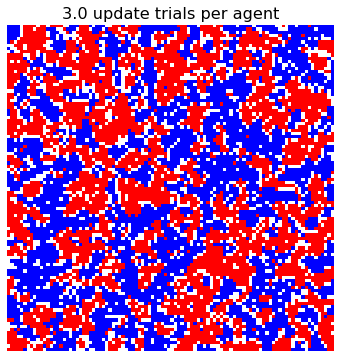

In [22]:
from functools import partial
if __name__=='__main__':
    # Parameters for running the model:
    n = 100               # Width of the grid
    m = 100               # Height of the grid
    p = 0.8               # Agent density (fraction of locations with agents)
    intolerance = 0.7     # Schelling intolerance level
    roundrobin = False    # Update method: if True -> round robin, if False -> with replacement
    updaterounds = 3      # Number of times updates are run per agent

    nagents = int(p*n*m)
    if not roundrobin: updaterounds = updaterounds*5
    sim = Simulation(n, m, nagents, parameters={"intolerance": intolerance})
    fig, ax = plt.subplots(figsize=(6, 6))
    ani = FuncAnimation(
        fig, partial(animate, sim, ax), frames=updaterounds,
        interval=1, repeat=False, fargs=(roundrobin, ))
    
    # Uncomment the following lines to save the animation as gif files:
    if roundrobin:
       ani.save('schelling_roundrobin.gif', writer=ImageMagickWriter(fps=3, extra_args=['-loop', '1']))
    else:
       ani.save('schelling.gif', writer=ImageMagickWriter(fps=15, extra_args=['-loop', '1']))


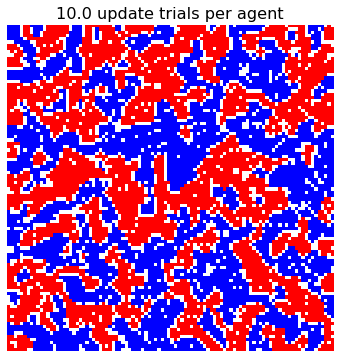

In [23]:
# Question 1

from functools import partial
if __name__=='__main__':
    # Parameters for running the model:
    n = 100               # Width of the grid
    m = 100               # Height of the grid
    p = 0.8               # Agent density (fraction of locations with agents)
    intolerance = 0.6     # Schelling intolerance level
    roundrobin = False    # Update method: if True -> round robin, if False -> with replacement
    updaterounds = 10      # Number of times updates are run per agent

    nagents = int(p*n*m)
    if not roundrobin: updaterounds = updaterounds*5
    sim = Simulation(n, m, nagents, parameters={"intolerance": intolerance})
    fig, ax = plt.subplots(figsize=(6, 6))
    ani = FuncAnimation(
        fig, partial(animate, sim, ax), frames=updaterounds,
        interval=1, repeat=False, fargs=(roundrobin, ))
    
    # Uncomment the following lines to save the animation as gif files:
    if roundrobin:
       ani.save('schelling_roundrobin_question1.gif', writer=ImageMagickWriter(fps=3, extra_args=['-loop', '1']))
    else:
       ani.save('schelling_question1.gif', writer=ImageMagickWriter(fps=15, extra_args=['-loop', '1']))

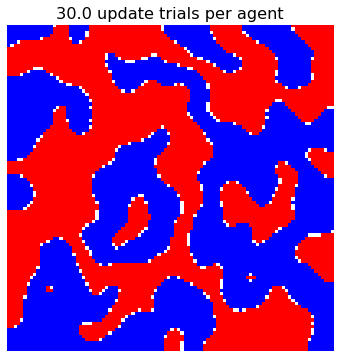

In [27]:
# Question 2

from functools import partial
if __name__=='__main__':
    # Parameters for running the model:
    n = 100               # Width of the grid
    m = 100               # Height of the grid
    #p = 0.3               # Agent density (fraction of locations with agents)
    p = 0.97               # Agent density (fraction of locations with agents)
    intolerance = 0.7     # Schelling intolerance level
    roundrobin = False    # Update method: if True -> round robin, if False -> with replacement
    updaterounds = 30      # Number of times updates are run per agent

    nagents = int(p*n*m)
    if not roundrobin: updaterounds = updaterounds*5
    sim = Simulation(n, m, nagents, parameters={"intolerance": intolerance})
    fig, ax = plt.subplots(figsize=(6, 6))
    ani = FuncAnimation(
        fig, partial(animate, sim, ax), frames=updaterounds,
        interval=1, repeat=False, fargs=(roundrobin, ))
    
    # Uncomment the following lines to save the animation as gif files:
    if roundrobin:
       ani.save('schelling_roundrobin_question2.gif', writer=ImageMagickWriter(fps=3, extra_args=['-loop', '1']))
    else:
       ani.save(f'schelling_question2_{p}.gif', writer=ImageMagickWriter(fps=15, extra_args=['-loop', '1']))

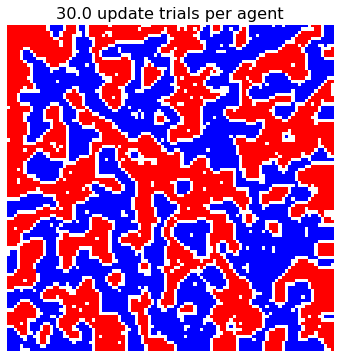

In [31]:
# Question 3

from functools import partial
if __name__=='__main__':
    # Parameters for running the model:
    n = 100               # Width of the grid
    m = 100               # Height of the grid
    p = 0.8               # Agent density (fraction of locations with agents)
    intolerance = 0.7     # Schelling intolerance level
    roundrobin = False    # Update method: if True -> round robin, if False -> with replacement
    #updaterounds = 5      # Number of times updates are run per agent
    #updaterounds = 10      # Number of times updates are run per agent
    updaterounds = 30      # Number of times updates are run per agent

    nagents = int(p*n*m)
    if not roundrobin: updaterounds = updaterounds*5
    sim = Simulation(n, m, nagents, parameters={"intolerance": intolerance})
    fig, ax = plt.subplots(figsize=(6, 6))
    ani = FuncAnimation(
        fig, partial(animate, sim, ax), frames=updaterounds,
        interval=1, repeat=False, fargs=(roundrobin, ))
    
    # Uncomment the following lines to save the animation as gif files:
    if roundrobin:
       ani.save('schelling_roundrobin_question3.gif', writer=ImageMagickWriter(fps=3, extra_args=['-loop', '1']))
    else:
       ani.save(f'schelling_question3_{updaterounds}.gif', writer=ImageMagickWriter(fps=15, extra_args=['-loop', '1']))

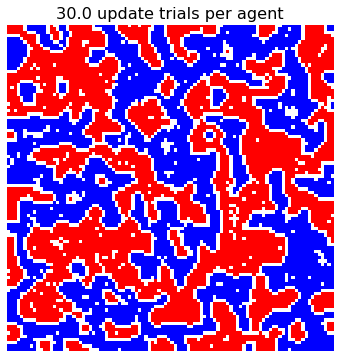

In [25]:
# Question 4

from functools import partial
if __name__=='__main__':
    # Parameters for running the model:
    n = 100               # Width of the grid
    m = 100               # Height of the grid
    p = 0.8               # Agent density (fraction of locations with agents)
    intolerance = 0.7     # Schelling intolerance level
    roundrobin = True    # Update method: if True -> round robin, if False -> with replacement
    updaterounds = 30      # Number of times updates are run per agent

    nagents = int(p*n*m)
    if not roundrobin: updaterounds = updaterounds*5
    sim = Simulation(n, m, nagents, parameters={"intolerance": intolerance})
    fig, ax = plt.subplots(figsize=(6, 6))
    ani = FuncAnimation(
        fig, partial(animate, sim, ax), frames=updaterounds,
        interval=1, repeat=False, fargs=(roundrobin, ))
    
    # Uncomment the following lines to save the animation as gif files:
    if roundrobin:
       ani.save('schelling_roundrobin_question4.gif', writer=ImageMagickWriter(fps=3, extra_args=['-loop', '1']))
    else:
       ani.save('schelling_question4.gif', writer=ImageMagickWriter(fps=15, extra_args=['-loop', '1']))